In [56]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os
from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime

from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick

from ultralytics import YOLO
import ultralytics
import seaborn as sns
from scipy import stats

In [2]:
ultralytics.checks()

Ultralytics YOLOv8.0.150  Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Setup complete  (24 CPUs, 15.7 GB RAM, 65.8/280.0 GB disk)


In [3]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "validation"
_calib_folder_name = "calibration_00"

# _folder_name = "ar_30_5_quad_random_slow_01"
_folder_name = "sk_30_4_random_00"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_validation_2.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


In [4]:
timeoffset = 0.0
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])

_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

#change string to float
_imu_df = _imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

In [5]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = int(_folder_name.split("_")[2])/100
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [6]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [7]:
            
def estimatePoseSingleMarkers(corners, marker_points, mtx, distortion):

    # marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
    #                           [marker_size / 2, marker_size / 2, 0],
    #                           [marker_size / 2, -marker_size / 2, 0],
    #                           [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [8]:
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_p2_60e_noise.pt')
model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_ar_200e_noise.pt')
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'best.pt')
yolo_model = YOLO(model_pth)
# model_pth

marker_size = markerLength

marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                            [marker_size / 2, marker_size / 2, 0],
                            [marker_size / 2, -marker_size / 2, 0],
                            [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)

In [9]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data_yolo = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    
    # YOLO
    yolo_results = yolo_model.predict(_frame, verbose=False, conf = 0.3, half = True)[0]
    modelcorners = []
    for _keys in yolo_results.keypoints.data:
        modelcorners.append(_keys[0:4].cpu().numpy())
    modelcorners = np.array(modelcorners)
    # print(modelcorners.shape)
    
    if len(yolo_results.boxes.cls.cpu().numpy()) != 0: # if there are any detections else None
        _idx = yolo_results.boxes.cls.cpu().numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([12])
                case 1:
                    ids.append([88])
                case 2:
                    ids.append([89])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None
        
    if len(modelcorners) != 0: # if there are any detections else skip
        try:
            y_rvec, y_tvec = estimatePoseSingleMarkers(modelcorners, marker_points, _webcam_cam_mat, _webcam_dist)
        except:
            ids = None
            
    if ids is None:
        data_yolo["frame_id"].append(counter)
        data_yolo["marker_ids"].append(None)
        data_yolo["corners"].append(None)
        data_yolo["tvec"].append(None)
        data_yolo["rvec"].append(None)

    if ids is not None:
        data_yolo["frame_id"].append(counter)
        data_yolo["marker_ids"].append(ids)
        data_yolo["corners"].append(modelcorners)
        data_yolo["tvec"].append(y_tvec)
        data_yolo["rvec"].append(y_rvec)
    counter += 1
_video_file.close()

0it [00:00, ?it/s]

845it [00:21, 39.49it/s]


In [10]:
data = data_yolo.copy()

In [11]:
coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])
            
        _zero_counter = 0            
        for j, _m in enumerate(data["marker_ids"][i]):
                
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

                
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
            
    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)
            
    doesnt_exist.clear()

In [12]:
print(len(coordinate[str(default_ids[0])]["y"]), len(coordinate[str(default_ids[1])]["y"]), len(coordinate[str(default_ids[2])]["z"]))

845 845 845


In [13]:
_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)), 'validation', f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [14]:
_om = get_rb_marker_name(2)
_xm = get_rb_marker_name(4)
_zm = get_rb_marker_name(1)

In [15]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [16]:
# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [17]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

  0%|          | 0/9323 [00:00<?, ?it/s]

100%|██████████| 9323/9323 [00:01<00:00, 6696.93it/s]


In [18]:
coordinate_ml = coordinate
data_ml = data

In [19]:
filter_size = 11
filter_order = 3

filter_0_df = pl.DataFrame(coordinate_ml[str(default_ids[1])])
# apply savgol filter for columns rx, ry, rz

filter_0_df = filter_0_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                            ])

In [20]:
rmat = []
for i in range(len(coordinate_ml[str(default_ids[1])]["x"])):
    rotation_vectors = np.array([coordinate_ml[str(default_ids[1])]["rx"][i], coordinate_ml[str(default_ids[1])]["ry"][i], coordinate_ml[str(default_ids[1])]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat.append(rotation_matrix)

In [21]:
# print(len(coordinate_ml["100"]["x"]), len(coordinate_ml["49"]["y"]), len(coordinate_ml["80"]["z"]), len(data_ml["frame_id"]))

In [22]:
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

In [23]:
# ts.append(ts[-1])
# ts.append(ts[-1])
ts_df = pd.DataFrame({"ts":ts})
ts_df["ts"] = pd.to_datetime(ts_df["ts"])

_ln = len(ts)

ar_df    = pl.DataFrame({"time":ts,"x":coordinate_ml[str(default_ids[1])]["x"][:_ln], "y":coordinate_ml[str(default_ids[1])]["y"][:_ln], "z":coordinate_ml[str(default_ids[1])]["z"][:_ln], "rx":coordinate_ml[str(default_ids[1])]["rx"][:len(ts)], "ry":coordinate_ml[str(default_ids[1])]["ry"][:len(ts)], "rz":coordinate_ml[str(default_ids[1])]["rz"][:len(ts)]})
ar_df_49 = pl.DataFrame({"time":ts,"x":coordinate_ml[str(default_ids[0])]["x"][:_ln], "y":coordinate_ml[str(default_ids[0])]["y"][:_ln], "z":coordinate_ml[str(default_ids[0])]["z"][:_ln]})
ar_df_80 = pl.DataFrame({"time":ts,"x":coordinate_ml[str(default_ids[2])]["x"][:_ln], "y":coordinate_ml[str(default_ids[2])]["y"][:_ln], "z":coordinate_ml[str(default_ids[2])]["z"][:_ln]})

if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

if type(ar_df_49["time"][0]) is not datetime:
    ar_df_49 = ar_df_49.with_columns(pl.col("time").str.to_datetime())
    
if type(ar_df_80["time"][0]) is not datetime:
    ar_df_80 = ar_df_80.with_columns(pl.col("time").str.to_datetime())

Bringing to skateboard frame

In [24]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 9323/9323 [00:00<00:00, 316148.80it/s]


In [25]:
_del_r_0 = []
for i in tqdm(range(len(rmat))):
    _del_r_0.append(rmat[i].T@rmat[0])

# calculating angle for mc
_theta_x_0 = []
_theta_y_0 = []
_theta_z_0 = []

for i in tqdm(_del_r_0):
    _theta_x_0.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y_0.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z_0.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x_0 = np.array(_theta_x_0)
_theta_y_0 = np.array(_theta_y_0)
_theta_z_0 = np.array(_theta_z_0)

# converting them to degrees
_theta_x_0 = np.rad2deg(_theta_x_0)
_theta_y_0 = np.rad2deg(_theta_y_0)
_theta_z_0 = np.rad2deg(_theta_z_0)

100%|██████████| 845/845 [00:00<00:00, 383321.10it/s]


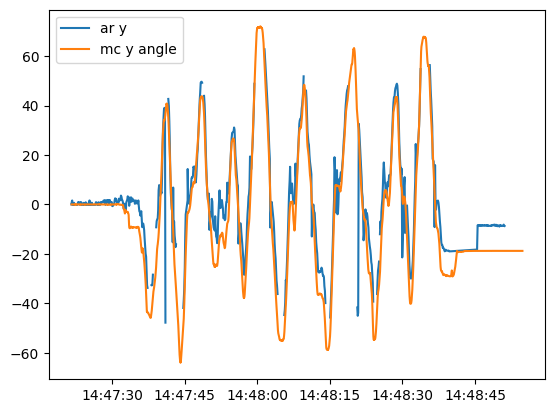

In [26]:
plt.plot(ar_df["time"], _theta_y_0, label = "ar y")
plt.plot(_mc_df["time"], _theta_y, label = "mc y angle")
plt.legend()

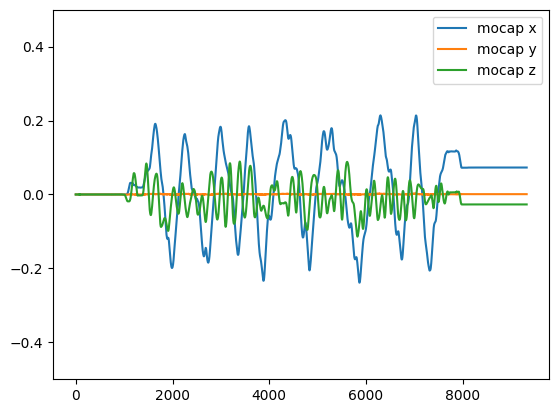

In [27]:
plt.plot(_mc_df["x"], label="mocap x")
plt.plot(_mc_df["y"], label="mocap y")
plt.plot(_mc_df["z"], label="mocap z")
plt.ylim(-0.5, 0.5)
plt.legend()

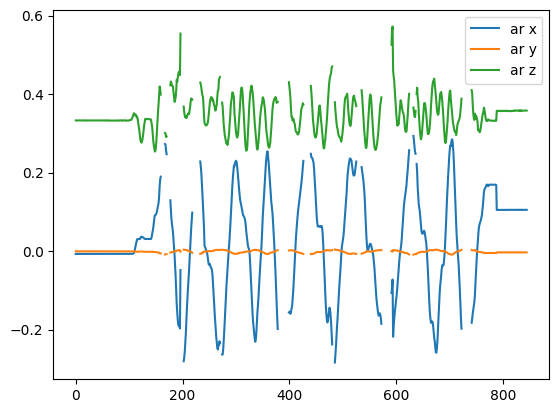

In [28]:
plt.plot(ar_df["x"], label="ar x")
plt.plot(ar_df["y"], label="ar y")
plt.plot(ar_df["z"], label="ar z")
plt.legend()

In [29]:
imu_df = _imu_df.clone()
cols = ["time", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz", "ang_x", "ang_y", "ang_z"]
imu_df = interpolate_target_df(imu_df, ar_df, cols)
imu_df = pl.from_pandas(imu_df)

In [30]:
_imurmat_x = []
_imurmat_y = []
_imurmat_z = []
_i_theta = 0
for i in range(len(imu_df)):
    _i_theta = np.deg2rad(-imu_df["ang_z"][i] + imu_df["ang_z"][0])
    
    _imurmat_y.append(np.array([[np.cos(_i_theta), 0, np.sin(_i_theta)],
                                [0, 1, 0],
                                [-np.sin(_i_theta), 0, np.cos(_i_theta)]]))

In [31]:
_imu_dr = []

for i in range(len(imu_df)):
    
    _dr = rmat[0] @ _imurmat_y[i].T
    _dr = _dr.T
    _imu_dr.append(_dr)

In [32]:
_mdf = _mocap_df.copy()
_cdf = ar_df.to_pandas()
_cols = []
for i in ["x", "y", "z"]:
    _cols.append(_om[i])
    _cols.append(_xm[i])
    _cols.append(_zm[i])
_cdf["time"] = pd.to_datetime(_cdf["time"])

In [33]:
_mo_df = interpolate_target_df(_mdf, _cdf, _cols)
_mo_df = pl.from_pandas(_mo_df)

In [34]:
#convert time to datetime format    
if type(ar_df["time"][0]) != datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())
if type(ar_df_49["time"][0]) != datetime:
    ar_df_49 = ar_df_49.with_columns(pl.col("time").str.to_datetime())
if type(ar_df_80["time"][0]) != datetime:
    ar_df_80 = ar_df_80.with_columns(pl.col("time").str.to_datetime())

Orthonormalizing rmat

Marker 0

In [35]:
rA_m1_d = np.array([0.0, 0.02, -0.13]).reshape(3, 1)

In [36]:

newdata = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):
    
    val = ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    pa_c = _imu_dr[i] @ rA_m1_d + val
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org )
    val = pa_b
    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val

    reval = (rotMat.T @ (rval - translation_correction)).T[0]

    newdata["x"].append(reval[0])
    newdata["y"].append(reval[1])
    newdata["z"].append(reval[2])

In [37]:
phi = np.pi/2
positive_90_rotation = np.array([[np.cos(phi), 0, np.sin(phi)],
                                [0, 1, 0],
                                [-np.sin(phi), 0, np.cos(phi)]])

negative_90_rotation = np.array([[np.cos(-phi), 0, np.sin(-phi)],
                                [0, 1, 0],
                                [-np.sin(-phi), 0, np.cos(-phi)]])

negative_90_rotation

array([[ 6.1232e-17,           0,          -1],
       [          0,           1,           0],
       [          1,           0,  6.1232e-17]])

Marker 49

In [38]:
rA_m1_49 = np.array([-0.055, 0.0, -0.075]).reshape(3, 1)

In [39]:

newdata_49 = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):
    val_49 = ar_df_49[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    pa_c = _imu_dr[i] @ positive_90_rotation @ rA_m1_49 + val_49
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org )
    val_49 = pa_b    
    
    if i == 0:
        initial = ar_df[["x", "y", "z"]][0].to_numpy().reshape(3,1)
    if val_49 is None:
        rval_49 = np.nan
    else:
        rval_49 = val_49

    reval_49 = (rotMat.T @ (rval_49)).T[0]

    newdata_49["x"].append(reval_49[0])
    newdata_49["y"].append(reval_49[1])
    newdata_49["z"].append(reval_49[2])

Marker 80

In [40]:
rA_m1_80 = np.array([0.055, 0.0, -0.075]).reshape(3, 1)

In [41]:

newdata_80 = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):

    val_80 = ar_df_80[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    pa_c = _imu_dr[i] @ negative_90_rotation @ rA_m1_80 + val_80
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org )
    val_80 = pa_b      
    
    if i == 0:
        initial = ar_df[["x", "y", "z"]][0].to_numpy().reshape(3,1)
    if val_80 is None:
        rval_80 = np.nan
    else:
        rval_80 = val_80 

    reval_80 = (rotMat.T @ (rval_80)).T[0]

    newdata_80["x"].append(reval_80[0])
    newdata_80["y"].append(reval_80[1])
    newdata_80["z"].append(reval_80[2])

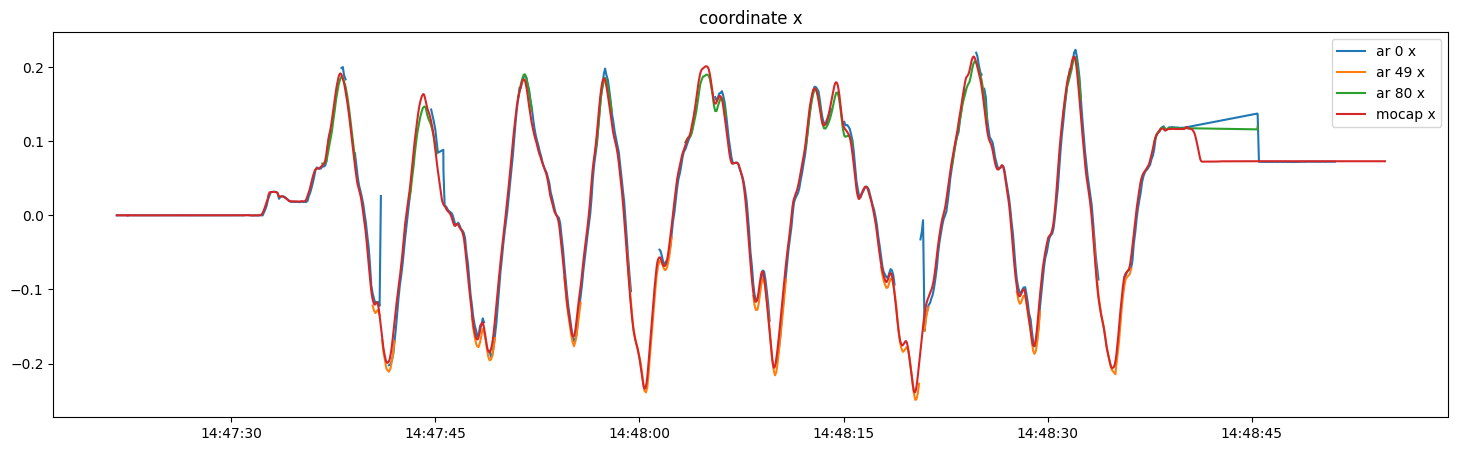

In [42]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],(np.array(newdata["x"]) - np.array(newdata["x"][0])), label="ar 0 x")
ax0.plot(ar_df["time"],np.array(newdata_49["x"]) - 0.04, label="ar 49 x")
ax0.plot(ar_df["time"],np.array(newdata_80["x"]) - 0.04, label="ar 80 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

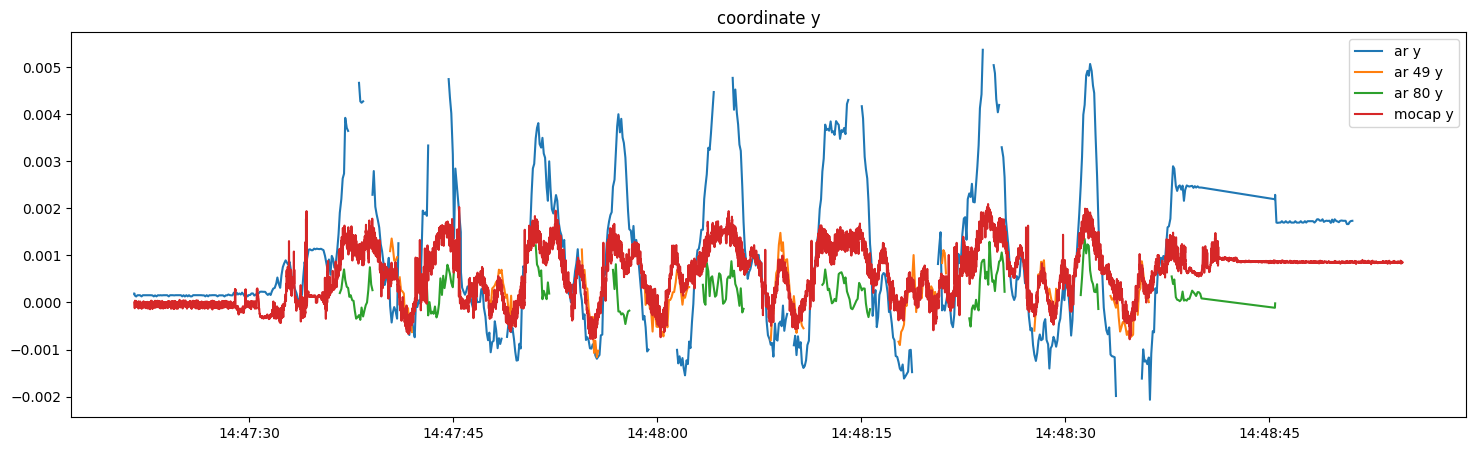

In [94]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["y"]) - 0.069, label="ar y")
ax0.plot(ar_df["time"],np.array(newdata_49["y"]) + 0.029, label="ar 49 y")
ax0.plot(ar_df["time"],np.array(newdata_80["y"]) +0.032, label="ar 80 y")
ax0.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")
# ax0.set_ylim(-0.1, 0.1)
ax0.set_title("coordinate y")
ax0.legend()

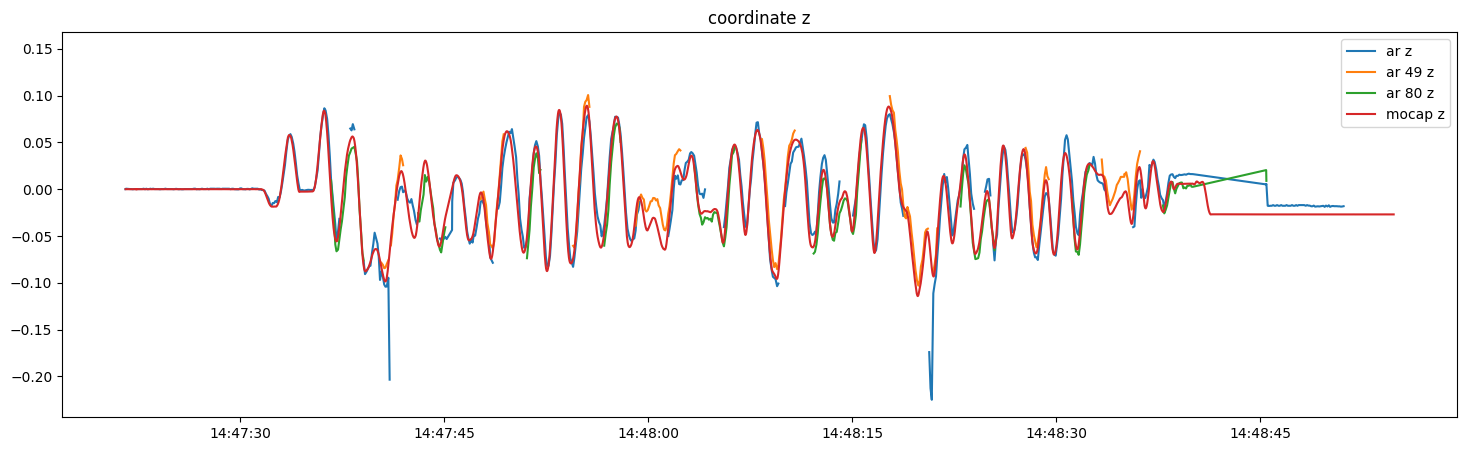

In [44]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],(np.array(newdata["z"]) - np.array(newdata["z"][0])), label="ar z")
ax0.plot(ar_df["time"],np.array(newdata_49["z"]) - 0.045, label="ar 49 z")
ax0.plot(ar_df["time"],np.array(newdata_80["z"]) - 0.045, label="ar 80 z")
ax0.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")

ax0.set_title("coordinate z")
ax0.legend()

Full plotting

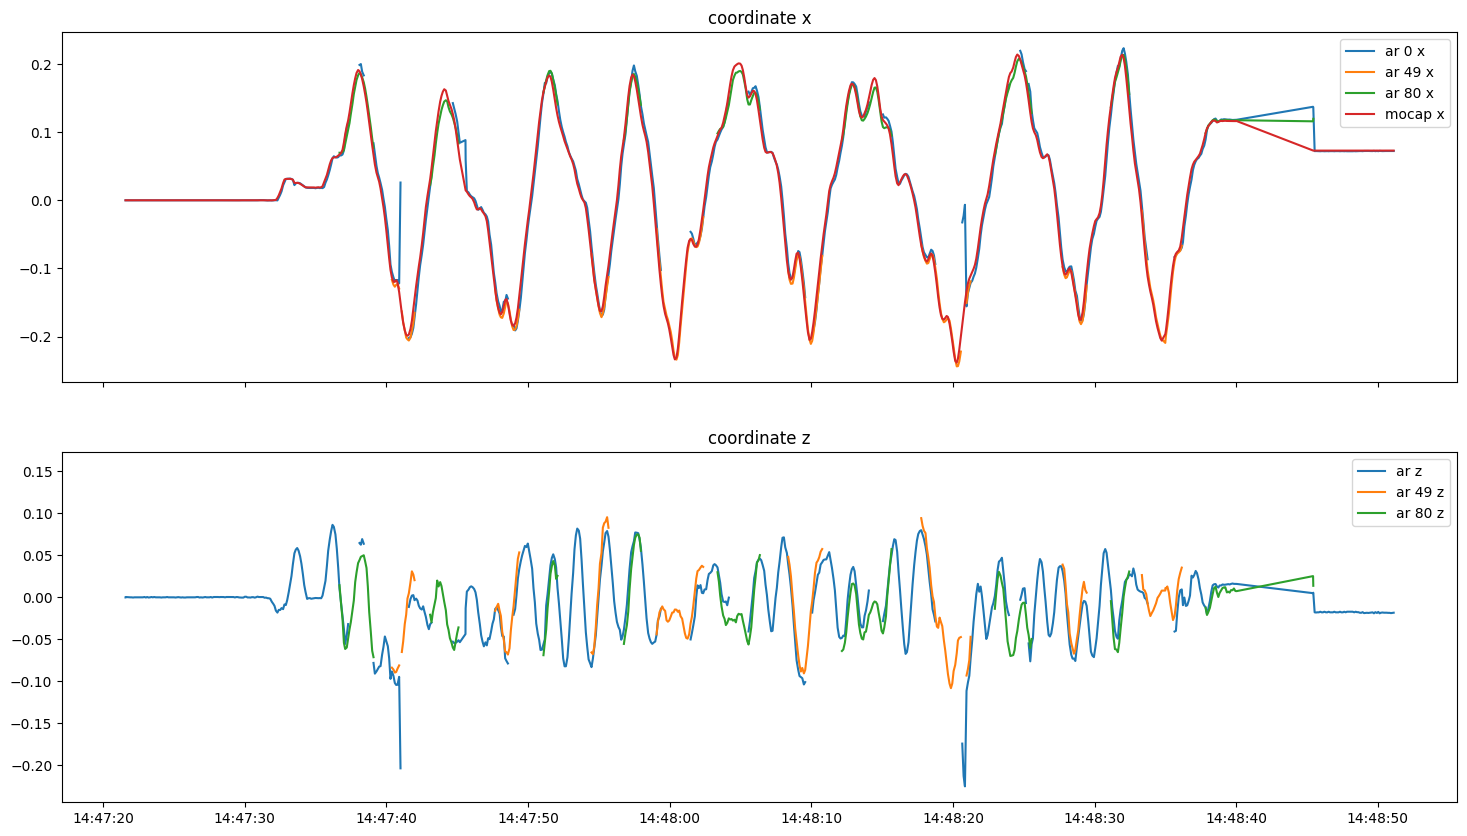

In [111]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True,
                                    figsize=(18, 10))

ax0.plot(ar_df["time"],(np.array(newdata["x"]) - np.array(newdata["x"][0])), label="ar 0 x")
ax0.plot(ar_df["time"],np.array(newdata_49["x"]) - 0.035, label="ar 49 x")
ax0.plot(ar_df["time"],np.array(newdata_80["x"]) - 0.04, label="ar 80 x")
ax0.plot(_mcc_df["time"],(_mcc_df['x'] - _mcc_df['x'][0]), label="mocap x")
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(ar_df["time"],(np.array(newdata["z"]) - np.array(newdata["z"][0])), label="ar z")
ax1.plot(ar_df["time"], np.array(newdata_49["z"]) - 0.05, label="ar 49 z")
ax1.plot(ar_df["time"], np.array(newdata_80["z"]) - 0.04, label="ar 80 z")
# ax1.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")
ax1.set_title("coordinate z")
ax1.legend()

In [145]:
validate = {'x':[], 'y':[], 'z':[]}

for i in range(len(newdata['x'])):

    _val_0 = np.array([newdata['x'][i] - newdata['x'][0], 
                       newdata['y'][i] - 0.069, 
                       newdata['z'][i]])
    
    _val_1 = np.array([newdata_49['x'][i] - 0.035, 
                       newdata_49['y'][i] + 0.029, 
                       newdata_49['z'][i] - 0.045])
    
    _val_2 = np.array([newdata_80['x'][i] - 0.04, 
                       newdata_80['y'][i] + 0.032, 
                       newdata_80['z'][i] - 0.045])
    
    trigger = True
    
    if not np.isnan(_val_0).all() and trigger:
        validate['x'].append(_val_0[0])
        validate['y'].append(_val_0[1])
        validate['z'].append(_val_0[2])
        trigger = False
    elif not np.isnan(_val_1).all() and trigger:
        validate['x'].append(_val_1[0])
        validate['y'].append(_val_1[1])
        validate['z'].append(_val_1[2])
        trigger = False
    elif not np.isnan(_val_2).all() and trigger:
        validate['x'].append(_val_2[0])
        validate['y'].append(_val_2[1])
        validate['z'].append(_val_2[2])
        trigger = False
    else:
        validate['x'].append(np.nan)
        validate['y'].append(np.nan)
        validate['z'].append(np.nan)

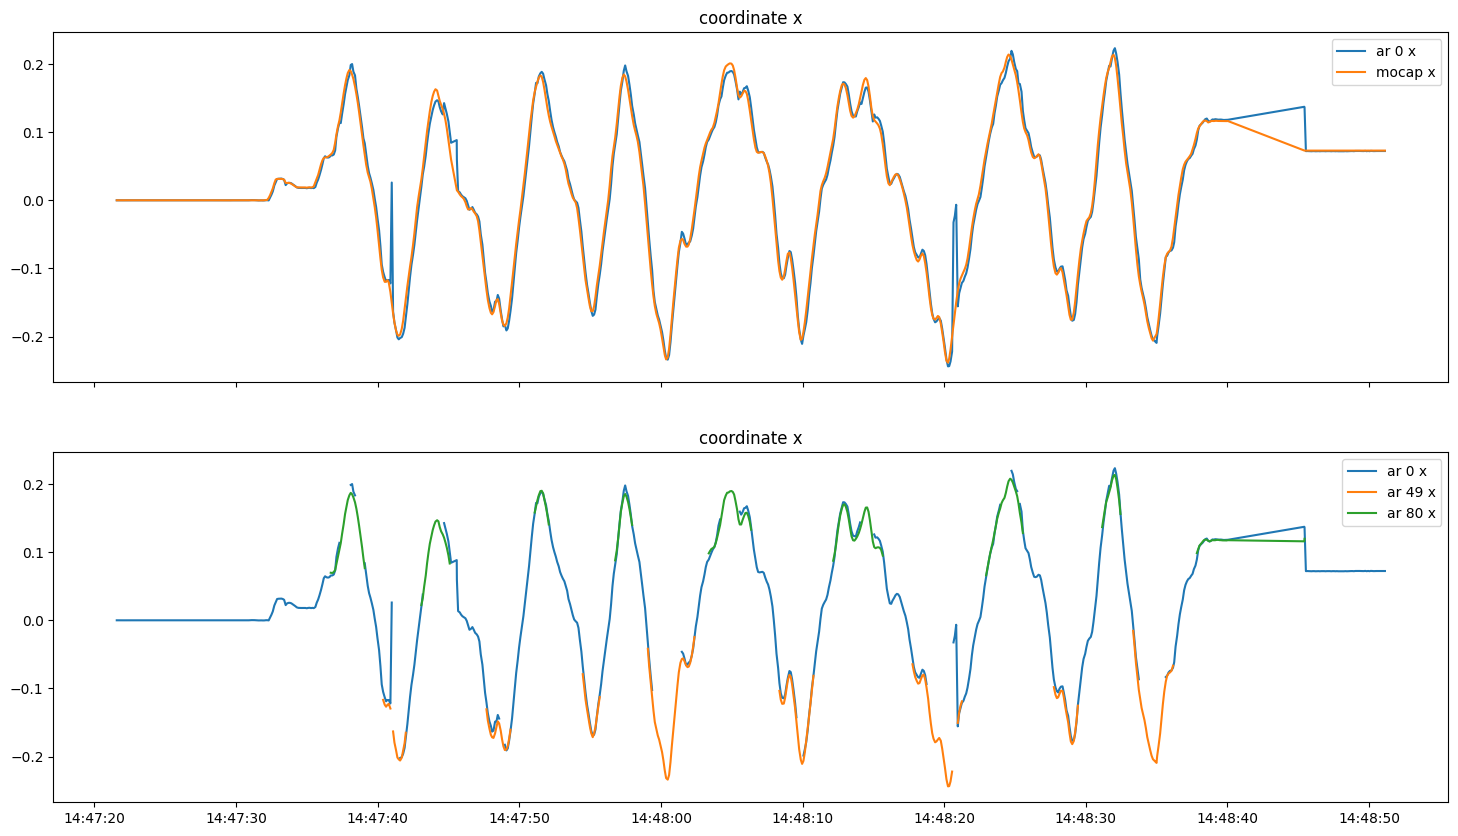

In [146]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True,
                                    figsize=(18, 10))

ax0.plot(ar_df["time"],(validate['x']), label="ar 0 x")
ax0.plot(_mcc_df["time"],(_mcc_df['x'] - _mcc_df['x'][0]), label="mocap x")
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(ar_df["time"],(np.array(newdata["x"]) - np.array(newdata["x"][0])), label="ar 0 x")
ax1.plot(ar_df["time"],np.array(newdata_49["x"]) - 0.035, label="ar 49 x")
ax1.plot(ar_df["time"],np.array(newdata_80["x"]) - 0.04, label="ar 80 x")
# ax1.plot(_mcc_df["time"],(_mcc_df['x'] - _mcc_df['x'][0]), label="mocap x")
# ax1.plot(ar_df["time"],(validate['x']), label="ar 0 x combined")

ax1.set_title("coordinate x")
ax1.legend()

In [147]:
_mcc_df = interpolate_target_df(_mc_df, _cdf, ['x', 'y', 'z'])
_mcc_df = pl.from_pandas(_mcc_df)


In [148]:
_err_x = validate['x'] - (_mcc_df['x'] - _mcc_df['x'][0]).to_numpy()
_err_y = validate['y'] - (_mcc_df['y'] - _mcc_df['y'][0]).to_numpy()
_err_z = validate['z'] - (_mcc_df['z'] - _mcc_df['z'][0]).to_numpy()

<Axes: >

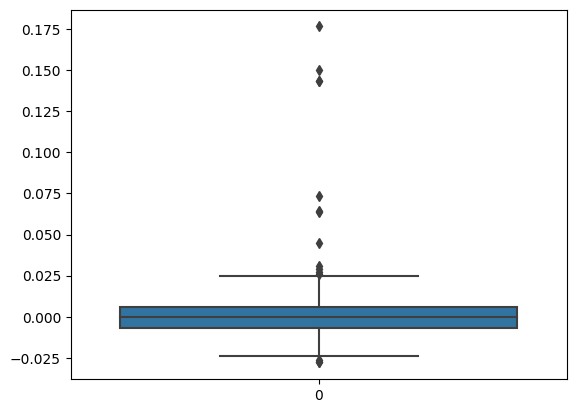

In [149]:
sns.boxplot(_err_x)

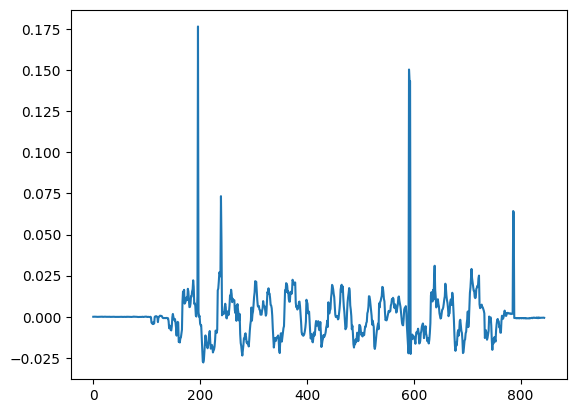

In [150]:
plt.plot()
plt.plot(_err_x)
# plt.plot(newdata['x'])

In [151]:
zscore_x = np.abs(stats.zscore(_err_x, nan_policy = 'omit'))
zscore_y = np.abs(stats.zscore(_err_y, nan_policy = 'omit'))
zscore_z = np.abs(stats.zscore(_err_z, nan_policy = 'omit'))
_zerr_x = _err_x[np.where(zscore_x < 2)]
_zerr_y = _err_y[np.where(zscore_y < 2)]
_zerr_z = _err_z[np.where(zscore_z < 2)]

In [152]:
print(np.nanmean(validate['x'] - (_mcc_df['x'] - _mcc_df['x'][0]).to_numpy()))
print(np.nanstd(validate['x'] - (_mcc_df['x'] - _mcc_df['x'][0]).to_numpy()))
print(np.nanmax(np.abs(validate['x'] - (_mcc_df['x'] - _mcc_df['x'][0]).to_numpy())))
print(np.nanmax(np.abs(_zerr_x)))

0.000609020967251942
0.015153418554818488
0.17651823319256887
0.029090224763951122


In [153]:
print(np.nanmean(validate['y'] - (_mcc_df['y'] - _mcc_df['y'][0]).to_numpy()))
print(np.nanstd(validate['y'] - (_mcc_df['y'] - _mcc_df['y'][0]).to_numpy()))
print(np.nanmax(np.abs(validate['y'] - (_mcc_df['y'] - _mcc_df['y'][0]).to_numpy())))
print(np.nanmax(np.abs(_zerr_y)))

0.0002469199020197575
0.0011361710250116749
0.0037500489024410335
0.0025109009318858063


In [154]:
print(np.nanmean(validate['z'] - (_mcc_df['z'] - _mcc_df['z'][0]).to_numpy()))
print(np.nanstd(validate['z'] - (_mcc_df['z'] - _mcc_df['z'][0]).to_numpy()))
print(np.nanmax(np.abs(validate['z'] - (_mcc_df['z'] - _mcc_df['z'][0]).to_numpy())))
print(np.nanmax(_zerr_z))

-0.001426139340317366
0.01502390912635238
0.14658763667666644
0.028422754455448885


In [155]:
# Count total number of elements in the array
total_elements = np.size(validate['z'])
# Count the number of NaN values in the array
nan_count = np.count_nonzero(np.isnan(validate['z']))

# Calculate the percentage of NaN values
percentage_nan = (nan_count / total_elements) * 100

print(f"Percentage of NaN values: {percentage_nan:.2f}%")

Percentage of NaN values: 0.00%
